# Perceptive Space Take Home Assigment

### Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import astrotools as at
import scipy as sc
import pandas as pd
import mplcursors
from mpl_toolkits.mplot3d import Axes3D


### Defining Constants and Central Body
The base unit for the rest of this assigment will be in kilometers. The Earth object contains physical values of the Earth such as the semi-major/minor axes, rotational rate, etc.

In [22]:
earth = at.MyWGS84("km") # Earth with units based on km
c = 299792458 * 1e-3 # speed of light in km/s

## Import and Clean GPS Measurements
The GPS measurement data is imported using Pandas and sorted via time and ordered by the ECEF column at each time step in [x,y,z] order. Velocity is converted from dm/s to km/s. 

In [23]:
# import data
df = pd.read_csv('GPS meas.csv')
df['time'] = pd.to_datetime(df['time'])

# sort by x, y, z
xyz_order = {'x': 1, 'y': 2, 'z': 3}
df['xyz_order'] = df['ECEF'].map(xyz_order)
df = df.sort_values(by=['time', 'xyz_order'])
df = df.drop(columns=['xyz_order'])

# extract x, y, z positions and velocities
sat = {}
sat['r_itrf'] = np.array([df[df['ECEF'] == 'x']['position'].values,
                          df[df['ECEF'] == 'y']['position'].values,
                          df[df['ECEF'] == 'z']['position'].values])
sat['v_itrf'] = np.array([df[df['ECEF'] == 'x']['velocity'].values,
                          df[df['ECEF'] == 'y']['velocity'].values,
                          df[df['ECEF'] == 'z']['velocity'].values]) / 1e4
clock_bias = np.array(df['clock'].values[0:-1:3])
date = df[df['ECEF'] == 'x']['time']

### Outlier Cleanup
The data has large outliers in position that are unrealistic for a Satellite orbit about the Earth, these values are removed from the data all vectors deriving from the measurements.

In [24]:
min_leo = earth.SemimajorAxis + 150 # minimum LEO radius
max_geo = earth.SemimajorAxis + 35786 + 300 # maximum geo radius

sat['r_mag'] = np.linalg.norm(sat['r_itrf'], axis=0)
keep_ind = (sat['r_mag'] >= min_leo) & (sat['r_mag'] <= max_geo)
sat['r_itrf'] = sat['r_itrf'][:, keep_ind]
sat['v_itrf'] = sat['v_itrf'][:, keep_ind]
sat['r_mag'] = sat['r_mag'][keep_ind]
date = date[keep_ind]
clock_bias = clock_bias[keep_ind] * 1e-6

### Date Extraction
The date and time are exported from the datetime column then converted the Julian Dates and GMST time angles (in degrees). There are also skips in the data that are roughly one day, these are detected and their indicies are saved.

In [25]:
# Extract year, month, and day with fractional time
year = date.dt.year.to_numpy()
month = date.dt.month.to_numpy()
day = date.dt.day.to_numpy()
frac = ((date.dt.hour + date.dt.minute / 60 + date.dt.second / 3600) / 24).to_numpy()

CalUTtoJD_vec = np.vectorize(at.CalUTtoJD)
JD = CalUTtoJD_vec(year,month,day,frac*24)
GMST, _ = at.JDtoGMST(JD,0)
N = len(JD)
dt = np.diff(JD) * 86400
day_skip = dt > dt[0] * 5

### Clock Bias Correction
The clock bias is used to correct both the position and velocity vectors using the speed of light since the bias is given in seconds.

In [26]:
p_corr = c * clock_bias
clock_drift = np.diff(clock_bias) / dt
for i in range(N):
    sat['r_itrf'][:,i] = (np.linalg.norm(sat['r_itrf'][:,i]) - (c * clock_bias[i])) * at.normalize(sat['r_itrf'][:,i])
    if i > 0:
        sat['v_itrf'][:,i] = sat['v_itrf'][:,i] - c * clock_drift[i-1] * at.normalize(sat['r_itrf'][:,i])


### Transformation from ECEF to ECI
Here, we are assuming the ECEF frame being used is the ITRF frame and the assumed ECI frame is J2000. Full rotation matrix transforms from the International Terrestrial Reference Frame (ITRF) [ECEF] -> Greenwich True of Date (GTOD) / Pesudo Earth-Fixed (PEF) [ECEF] -> True of Date (TOD) [ECI] -> Mean of Date (MOD) [ECI] -> J2000 frame [ECI] frame. The Greenwich Mean Sidreal Time (GMST) is used for the Earth rotation transformation matrix, the nutation transformation uses the IAU1980 nutation model, and the polar motion transformation uses the Earth Orientation parameters. Both the position and velocity are rotated into the J2000 frame.

In [27]:
EOP2 = at.parseEOPFile("./astrotools/EOP2long.txt") # inport Earth Orientation Parameters for polar motion rotation
sat['r_j2000'] = np.zeros_like(sat['r_itrf'])
sat['v_j2000'] = np.zeros_like(sat['v_itrf'])
for i in range(len(sat['r_itrf'][0])):
    R_earthrot = at.rot(GMST[i], 3, "degrees")
    R_nutation = at.RotNutation(JD[i], "UT1").T
    R_precession = at.RotPrecession(JD[i], "UT1").T
    R_polarmotion = at.RotPolarMotion(JD[i], EOP2).T
    full_rot = R_precession.T @ R_nutation.T @ R_earthrot.T @ R_polarmotion.T
    sat['r_j2000'][:,i] = full_rot @ sat['r_itrf'][:,i]
    sat['v_j2000'][:,i] = full_rot @ sat['v_itrf'][:,i]


## 1. Tracking and Filtering 
A Kalman filter will be used in particular an Extended Kalman Filter (EKF). This is because the orbit determination problem is nonlinear. The EKF algorithm effectively linearizes the nonlinear dynamics at each time step in order to propagate the system and estimate forward.

### Extended Kalman Filter Parameters
The tuning values for the the EKF are the process noise covariance matrix and the measurement noise covariance. These take into account the uncertainty of the model/dynamics and the measurements respectively. 

The measurement noise covariance matrix is based on rough estimates of the accuracy of GPS measurements and the process noise is tuned via trial and error and informed by the dynamics of the system. The system that is tracked is a nonlinear dynamical system with perturbations from external forces so this is taken into account. 

The initial state covariance matrix, P_est, is chosen

In [28]:
# Initialize process noise covariance matrix (Q)
q1 = 1e-5
q2 = 1e-7
Q = np.diag([q1, q1, q1, q2, q2, q2])

# Initialize measurement noise covariance matrix (R)
# assume 10 meter accuracy in gps
r1 = (10. * 1e-3)**2
# r1 = 1e-4
# assume .5 meter/sec accuracy in gps
r2 = (0.1 * 1e-3)**2
# r2 = 1e-8
R = np.diag([r1, r1, r1, r2, r2, r2])

# Initialize state covariance matrix (P)
# P_est = np.eye(6)
p_var = r1
v_var = r2
P_est = np.diag([p_var, p_var, p_var, v_var, v_var, v_var])

### Vector Initialization and Force Model Paramaters
Since the GPS measurement is real world data, the two body system is insufficient to fully model the system as additional forces such as the nonuniform gravity field, third body effects, and drag play a role in how an object in space moves. There is a trade-off between model accuracy and computational load so a compromise has to be made. The gravity model will include the standard two-body Newtonian model as well as zonal harmonics (due to the oblateness of the Earth) up to the 6th term (J2-J6) will be used, the use of a full spherical harmonic expansion of Earth's gravity model may be used as well, but due to the computational load, is ignored. Since the orbit of the object is so close to the Earth compared to other bodies (within LEO), third body effects from the moon and other bodies will be ignored. Aerodynamic drag is fairly easy to compute as well with a simple model of the air density with respect to the altitude of an object, but more in depth models would require more computations.

In [29]:
## Initialize estimation array
x_est = np.zeros([6, N]);  
x_est[:, 0] = np.concatenate((sat['r_j2000'][:,0], sat['v_j2000'][:,0]))
dt_min = np.min(dt)


# gravity parameters
max_degree = 6
earth.read_egm('./astrotools/EGM2008_to360.txt', max_degree)
# aerodynamic parameters (assumed shape and size)
Cd = 2.2
sarea = 10 / (1e3)**2 # surface area in km^2

### EKF Loop
The EKF loops through each time point first computing a prediction of the state. With the presence of large jumps in time and the removal of outliers, and the low density of measurements in time coupled with the fact that the low orbit (higher instantaneous velocity), the prediction step size has to be much smaller. A modified 4th order runge-kutta is used, the modifications include subsampling between the measurements by doing propagating with smaller time steps up to the next measurement and taking the final value. The predicted values are based on the model mentioned in the previous section.

Once the prediction is made, the Jacobian of a two-body system is used to create the state transition matrix to propagate the covariance matrix foward in time. A two-body model is used to propagate the matrix due to the complexity of taking the Jacobian of higher fidelity models. The Jacobian of the dynamics effectively linearizes the model at the time step for use in the EKF.

The predicted state covariance matrix is used to compute the Kalman gain. Since the measurements are given in the position and velocity, the observation matrix is a simple 6x6 identity matrix and is used to compute the Kalman gain matrix, K. The next set of measurements is taken and the difference between the measurements and the predicted values is used as the innovation along with the Kalman gains in order to estimate the state at the next time step. The estimate for the state covariance matrix is also computed. This process is looped until the last estimate is made with the last measurement. 

In [30]:
for k in range(N-1):
    # Prediction step
    r = np.linalg.norm(x_est[0:3, k])  # Compute the magnitude of the position vector

    f = lambda t,x: at.orbit_ode(t, x, 
                                 earth.mu, gravity="J", 
                                 max_degree=max_degree, Re=earth.SemimajorAxis, 
                                 C=earth.C, S=earth.S, GMST=GMST[k], J=earth.J,
                                 atmosphere="simple",Cd=Cd,sarea=sarea, omega=earth.omega)

    if dt[k] > dt_min * 1e1:
        ns = 1500
    elif dt[k] > dt_min * 3:
        ns = 36
    else:
        ns = 18
    _, x_pred = at.rk4_substeps(f, 0, x_est[:, k], dt[k], num_substeps=ns)

    # Jacobian (F_k) for state transition, initialization
    par2body = np.eye(3) * (-earth.mu / r**3)
    # Loop to modify the par2body matrix
    for i in range(3):
        for j in range(3):
            par2body[i, j] += 3 * earth.mu / r**5 * x_est[i, k] * x_est[j, k]

    # State transition Jacobian F
    F = np.block([[np.zeros((3, 3)), np.eye(3)], [par2body, np.zeros((3, 3))]])
    STM = np.eye((6)) + F * dt[k]
    # STM = dt[k] * F
    
    # Covariance prediction
    P_pred = STM @ P_est @ STM.T + Q

    # Kalman Gain
    H = np.eye(6)  # Measurement matrix
    S = H @ P_pred @ H.T + R  # Innovation covariance
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain
    
    # Measurement update
    z_k = np.concatenate((sat['r_j2000'][:,k+1], sat['v_j2000'][:,k+1]))    
    innovation = z_k - H @ x_pred

    x_est[:,k+1] = x_pred + K @ innovation # Update state estimate
    P_est = (np.eye(6) - K @ H) @ P_pred # Covariance update

### Plotting Orbit (3D)


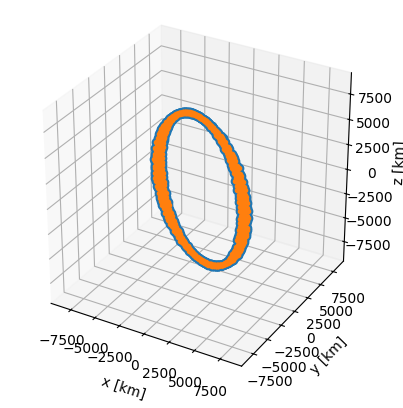

In [40]:
ax = plt.figure().add_subplot(projection="3d")
ax.plot(sat['r_j2000'][0],sat['r_j2000'][1],sat['r_j2000'][2],label="SV Trajectory",marker="o",linestyle='None')
# ax = at.plotsphere(ax,earth.SemimajorAxis)
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_zlabel("z [km]")
lim = 1.5*earth.SemimajorAxis
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim,lim])
ax.set_zlim([-lim,lim])
ax.set_aspect('equal')
ax.plot(x_est[0,:],x_est[1,:],x_est[2,:],label="Estimated Trajectory",marker=".",linestyle="None")
plt.show()

Plotting in 3D is usefull for a quick look at the orbit, but analysis should be done component-wise as seen in the next section.

### Component Residuals

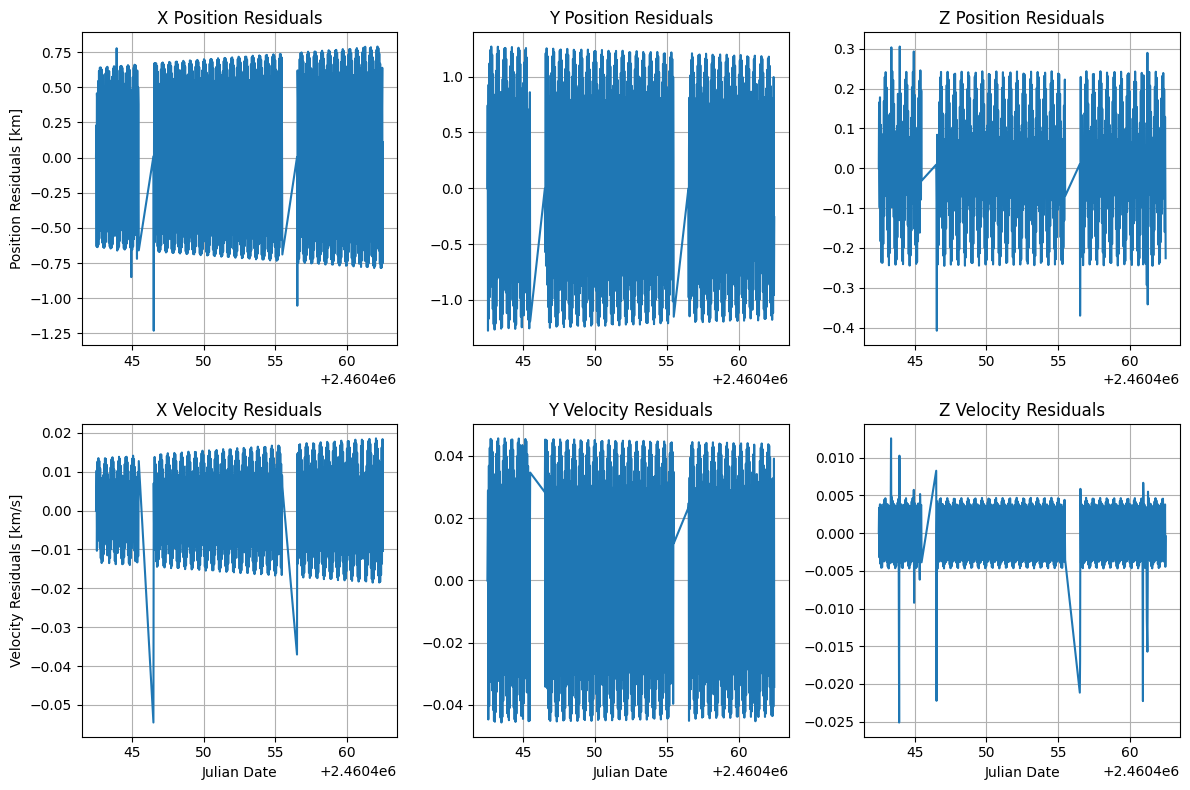

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# First row (position residuals for each axis)
axes[0, 0].plot(JD, (x_est[0, :] - sat['r_j2000'][0, :]))
axes[0, 0].set_title('X Position Residuals')
axes[0, 0].set_ylabel("Position Residuals [km]")
axes[0, 0].grid()

axes[0, 1].plot(JD, (x_est[1, :] - sat['r_j2000'][1, :]))
axes[0, 1].set_title('Y Position Residuals')
axes[0, 1].grid()

axes[0, 2].plot(JD, (x_est[2, :] - sat['r_j2000'][2, :]))
axes[0, 2].set_title('Z Position Residuals')
axes[0, 2].grid()

# Second row (velocity residuals for each axis)
axes[1, 0].plot(JD, (x_est[3, :] - sat['v_j2000'][0, :]))
axes[1, 0].set_title('X Velocity Residuals')
axes[1, 0].set_ylabel("Velocity Residuals [km/s]")
axes[1, 0].grid()

axes[1, 1].plot(JD, (x_est[4, :] - sat['v_j2000'][1, :]))
axes[1, 1].set_title('Y Velocity Residuals')
axes[1, 1].grid()

axes[1, 2].plot(JD, (x_est[5, :] - sat['v_j2000'][2, :]))
axes[1, 2].set_title('Z Velocity Residuals')
axes[1, 2].grid()

# Set a common xlabel for the bottom row
for ax in axes[1, :]:
    ax.set_xlabel("Julian Date")

plt.tight_layout()
plt.show()

Looking at the position residuals, the magnitudes of the residuals are within 1 kilometer at the worse. With the velocity residuals, the magnitudes of the residuals are even lower with an error of less than 0.05 km/s.

There are notable deviations around certain time intervals (around JD+start +45 and +55), suggesting potential issues with estimation during these periods, possibly linked to maneuvers or unmodeled dynamics. The residuals show periodic oscillations in all components. This is normal in orbit determination, where dynamic effects such as higher orders of gravitational expansions, atmospheric drag, or perturbations are present. The oscillations suggest that the model is capturing the overall dynamics, but fine-tuning may still be needed.

The residuals are generally within expected bounds for both position and velocity, though the relatively large spikes in position residuals (e.g., ±1 km) might indicate the need for further tuning in the filter's covariance matrices or the inclusion of additional dynamic models

### Orbit Energy Plot
The orbital energy plot shows that the estimate gives a slightly less negative orbital energy but is fairly to that computed from the measurements.

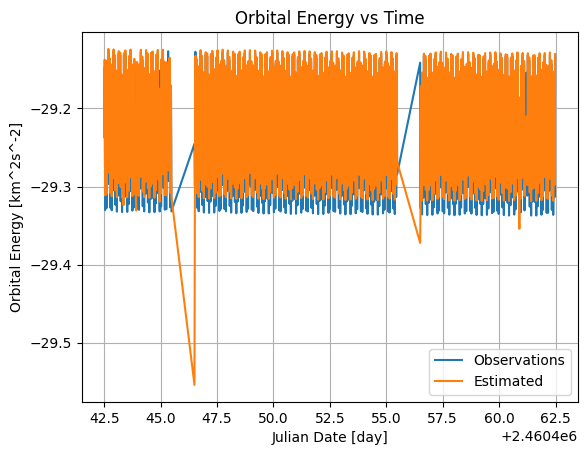

In [33]:
plt.figure()
E = at.orbit_energy(sat['r_j2000'], sat['v_j2000'], earth.mu)
E_est = at.orbit_energy(x_est[0:3,:], x_est[3:6,:], earth.mu)
plt.plot(JD,E,label="Observations")
plt.plot(JD,E_est,label="Estimated")
plt.legend()
plt.grid()
plt.xlabel("Julian Date [day]")
plt.ylabel("Orbital Energy [km^2s^-2]")
plt.title("Orbital Energy vs Time")
plt.show()

#

## 2. Maneuver Detection

### Using Velocity Magnitude Residuals
To detect manuevers, the velocity residual magitude will be used. This is because the estimates are determined using a propagation without maneuvers in mind, so it will "assume" motion based only on the system dynamics without control. Maneuvers cause deviation in the velocity from estimate so the residuals at these points will increase in magnitude. The velocity of a circular is constant, but since the orbit of the given object is slightly eccentric, the magnitude of the velocity will be sinusoidal, so a threshold can be used on the velocity magnitude residuals in order to detect any maneuvers. This threshold is chosen based on the plot of the residuals. 

In [34]:
v_res = np.linalg.norm(x_est[3:6,:] - sat['v_j2000'], axis=0)
# v_threshold = 0.05  # Threshold for velocity residuals in km/s
v_threshold = np.mean(v_res) + 1.25 * np.std(v_res)
# Initialize arrays to store detection data
man_detect = np.zeros(N, dtype=bool)

# Loop through the time steps separately for maneuver detection
for k in range(N):
    if v_res[k] > v_threshold:
        man_detect[k] = True

# Find indices where maneuvers were detected
maneuver_indices_velocity = np.where(man_detect == True)[0]
print("Maneuvers detected by velocity residuals at time steps:", maneuver_indices_velocity)

Maneuvers detected by velocity residuals at time steps: [140 141 572]


### Plot Residuals and Maneuver Threshold

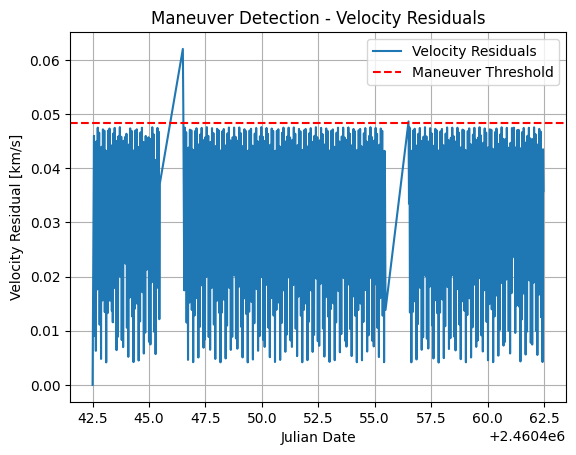

In [35]:
plt.figure()
plt.plot(JD, v_res, label="Velocity Residuals")
plt.axhline(y=v_threshold, color='r', linestyle='--', label="Maneuver Threshold")
plt.xlabel("Julian Date")
plt.ylabel("Velocity Residual [km/s]")
plt.legend()
plt.title("Maneuver Detection - Velocity Residuals")
plt.grid()
plt.show()

This algorithm detects maneuvers around the day jumps. This makes sense because, measurements are often halted while maneuvers are taking place.

## 3. Propagate into the Future
For the propagation of the object into the future, the same modified runge-kutta will be used with a sampling step size of 30 minutes (1800 seconds) in order the match step sizes given by the measurements. Each step will be sub-divided into 30 partitions, giving a simulation step size of of 1 minute (60 seconds). This time, without the load of the Kalman filter computations, a 10x10 spherical harmonic expansion of the gravity field will be used along with the same atmospheric model for drag. The simulation will run starting at the time of the last measurement using the estimate three days into the future.

In [36]:
earth.read_egm('./astrotools/EGM2008_to360.txt', max_degree)

JD_start = JD[-1]
JD_end =  JD_start + 3
dt_prop = 1800 # propagation step size of 30 minutes
N_prop = int((JD_end - JD_start)*86400/dt_prop)
JD_prop = np.linspace(JD_start, JD_end, N_prop)
dt_prop = np.diff(JD_prop) * 86400
GMST_prop, _ = at.JDtoGMST(JD_prop,0)

x_prop = np.zeros((6,N_prop))
x_prop[:,0] = x_est[:,-1]

for k in range(N_prop-1):
    # propagate at 60 second intervals, sample at 30 minutes
    f = lambda t,x: at.orbit_ode(t, x, 
                                 earth.mu, gravity="sphharmon", 
                                 max_degree=max_degree, Re=earth.SemimajorAxis, 
                                 C=earth.C, S=earth.S, GMST=GMST_prop[k], J=earth.J,
                                 atmosphere="simple",Cd=Cd,sarea=sarea, omega=earth.omega)
    _, x_prop[:,k+1] = at.rk4_substeps(f, 0, x_prop[:,k], dt_prop[k], num_substeps=30) 

r_mag_prop = np.linalg.norm(x_prop[:3], axis=0)
v_mag_prop = np.linalg.norm(x_prop[3:], axis=0)

### Plotting Propagation

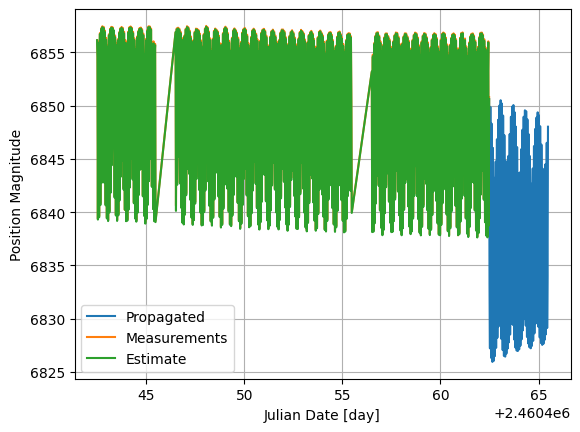

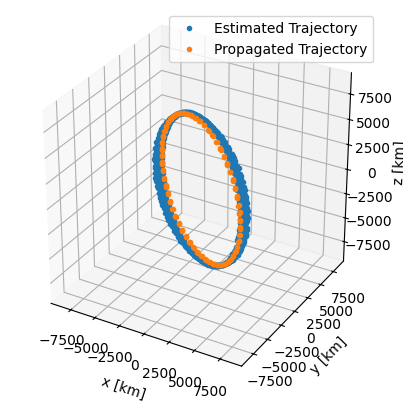

In [37]:

plt.figure()
plt.plot(JD_prop,r_mag_prop, label='Propagated')
plt.plot(JD,np.linalg.norm(sat['r_j2000'], axis=0), label='Measurements')
plt.plot(JD,np.linalg.norm(x_est[:3], axis=0), label="Estimate")
plt.legend()
plt.grid()
plt.ylabel("Position Magnitude")
plt.xlabel("Julian Date [day]")

ax = plt.figure().add_subplot(projection="3d")
ax.plot(x_est[0,:],x_est[1,:],x_est[2,:],label="Estimated Trajectory",marker=".",linestyle='None')
ax.plot(x_prop[0,:],x_prop[1,:],x_prop[2,:],label="Propagated Trajectory",marker=".",linestyle="None")
ax.set_xlabel("x [km]")
ax.set_ylabel("y [km]")
ax.set_zlabel("z [km]")
lim = 1.5*earth.SemimajorAxis
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim,lim])
ax.set_zlim([-lim,lim])
ax.set_aspect('equal')
ax.view_init(elev=30, azim=45)
plt.title("Propagated 3 Days")
plt.legend()

plt.show()

Looking at the position magnitudes, it can be seen that propagated positions display the same oscillations that are typical in orbits due to perturbations, but the propagated values seem to be offset from the measurements and estimated values. This can be due to the imperfect estimate used as the initial condition. The velocity may be off in magnitude or direction, which can cause a small orbit as seen in the results. 